In [1]:
from astropy.io import fits
import astropy.units as u
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks
from scipy.signal import resample

from rascal.calibrator import Calibrator
from rascal.util import refine_peaks

%matplotlib inline

/usr/local/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
data = fits.open('data_wht_isis/r2701004_red_arc.fit')[1]

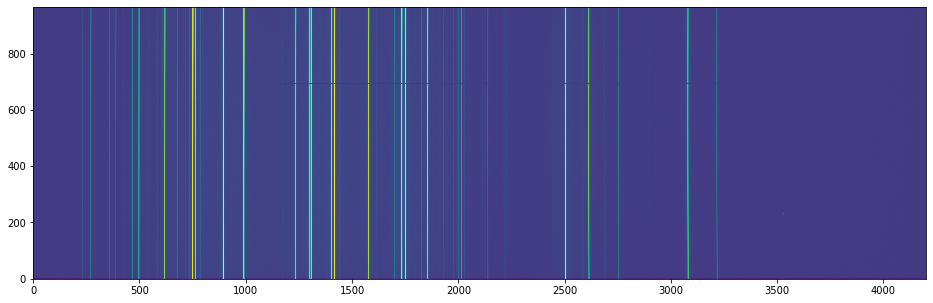

In [3]:
plt.figure(1, figsize=(16,5))
plt.imshow(np.log(data.data.T), aspect='auto', origin='lower')

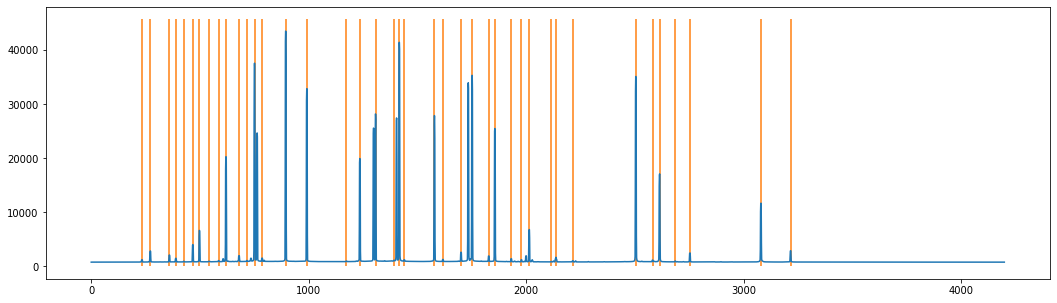

In [4]:
spectrum = np.median(data.data.T, axis=0)

peaks, _ = find_peaks(spectrum, prominence=80, distance=20, threshold=None)

peaks_refined = refine_peaks(spectrum, peaks, window_width=3)
plt.figure(figsize=(18,5))
plt.plot(spectrum)
plt.vlines(peaks_refined,
              0,
              1.05*spectrum.max(),
              colors='C1')

In [5]:
c = Calibrator(peaks_refined,
               min_wavelength=7000.,
               max_wavelength=10500.,
               num_pixels=len(spectrum))

c.use_plotly()
c.use_matplotlib()

c.set_fit_constraints(ransac_thresh=3, range_tolerance=750., fittype='poly')
c.add_atlas(["Ne", "Ar", "Cu"])

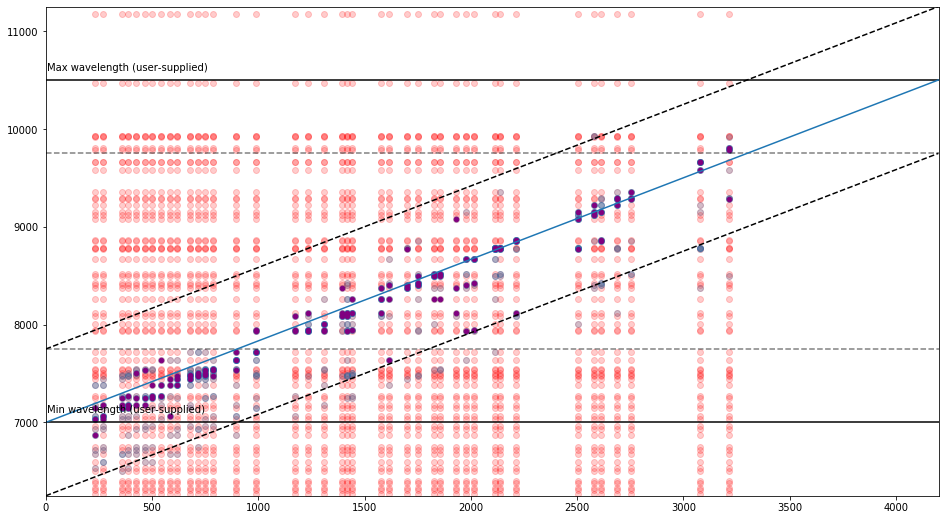

In [6]:
c.plot_search_space()

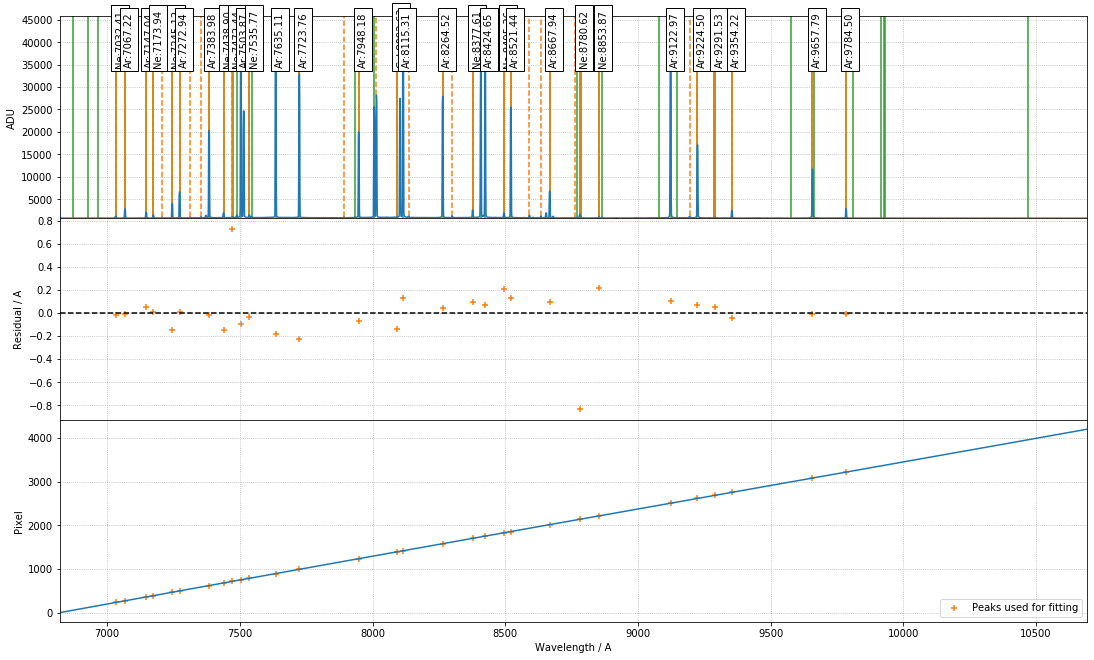

Stdev error: 0.22734587972459147 A
Peaks utilisation rate: 73.17073170731707%


In [7]:
final_tolerance = 2.

best_p, rms, residual, peak_utilisation = c.fit(max_tries=10000)
best_p, x_fit, y_fit, residual, peak_utilisation = c.match_peaks_to_atlas(best_p, tolerance=5.)
best_p, x_fit, y_fit, residual, peak_utilisation = c.match_peaks_to_atlas(best_p, tolerance=final_tolerance)

c.plot_fit(spectrum, best_p, plot_atlas=True, log_spectrum=False, tolerance=final_tolerance, renderer='notebook')

fit_diff = c.polyval(x_fit, best_p) - y_fit

rms = np.sqrt(np.sum(fit_diff**2 / len(x_fit)))

print("Stdev error: {} A".format(fit_diff.std()))
print("Peaks utilisation rate: {}%".format(peak_utilisation*100))